In [16]:
# script that analyzes and computes figures for experimental data on HCFC1 and CREBZF
import db_utils
import AF_plot_functions
import pandas
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import leastsq
from matplotlib import gridspec
import matplotlib
#matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'Arial'
%matplotlib inline

from matplotlib.ticker import FormatStrFormatter

connect = db_utils.get_connection()
cursor = connect.cursor()

path = '/Users/luck/IMB/projects/AlphaFold/exp_data_analysis/'

In [17]:
def get_saturation_curve_data(project_id,NL_id,mCit_id,connect,FL_id):
    titration_query = f"""select a.project_id,a.NL_plasmid,a.mCit_plasmid,a.NL_property,a.mCit_property,
                c.measurement/d.measurement BRET,a.NL_plasmid_id,a.mCit_plasmid_id,a.plate_id,b.avg_FL,
                e.measurement totLu 
                from luthy_data.plate_layout a, luthy_data.FL_avg_points b, luthy_data.LU_raw c, 
                    luthy_data.LU_raw d, luthy_data.LU_raw e 
                where a.project_id='{project_id}' and a.include=1 and a.project_id=b.project_id and 
                    a.project_id=c.project_id and a.project_id=d.project_id and a.project_id=e.project_id and 
                    a.plate_id=b.plate_id and a.plate_id=c.plate_id and a.plate_id=d.plate_id and 
                    a.plate_id=e.plate_id and a.well_id=b.well_id and a.well_id=c.well_id and 
                    a.well_id=d.well_id and a.well_id=e.well_id and a.NL_plasmid_id='{NL_id}' and 
                    a.mCit_plasmid_id='{mCit_id}' and c.measurement_id='accLu01' and d.measurement_id='donLu01' 
                    and e.measurement_id='totLu01' and b.measurement_id='{FL_id}'"""
    bleedthrough_query = f"""select c.measurement/d.measurement bleedthrough,a.plate_id
                from luthy_data.plate_layout a, luthy_data.LU_raw c, luthy_data.LU_raw d
                where a.project_id='{project_id}' and a.include=1 and a.project_id=c.project_id and 
                    a.project_id=d.project_id and a.plate_id=c.plate_id and a.plate_id=d.plate_id and 
                    a.well_id=c.well_id and a.well_id=d.well_id and a.NL_plasmid_id='KL_03' and 
                    a.mCit_plasmid_id='empty' and c.measurement_id='accLu01' and d.measurement_id='donLu01'"""
    bkg_query = f"""select b.avg_FL bkg_FL,c.measurement bkg_LU,a.plate_id
                    from luthy_data.plate_layout a, luthy_data.FL_avg_points b, luthy_data.LU_raw c 
                    where a.project_id='{project_id}' and a.include=1 and a.project_id=b.project_id and 
                        a.project_id=c.project_id and a.plate_id=b.plate_id and a.plate_id=c.plate_id and 
                        a.well_id=b.well_id and a.well_id=c.well_id and a.NL_plasmid_id='KL_01' and 
                        a.mCit_plasmid_id='empty' and b.measurement_id='{FL_id}' and c.measurement_id='totLu01'"""

    BRET_df = pandas.read_sql(titration_query,connect)
    BT_df = pandas.read_sql(bleedthrough_query,connect)
#    print(BT_df)
    bkg_df = pandas.read_sql(bkg_query,connect)
#    print(bkg_df)
    
    BRET_df['norm_BRET'] = BRET_df['BRET'] - np.mean(list(BT_df['bleedthrough']))
    BRET_df['expr_ratio'] = (BRET_df['avg_FL'] - np.mean(list(bkg_df['bkg_FL'])))/(BRET_df['totLu'] - np.mean(list(bkg_df['bkg_LU'])))
#    print(BRET_df)
    
    return BRET_df

('KL_611', 'KL_648', 'Lu126r01', 'FL01')
   project_id               NL_plasmid               mCit_plasmid NL_property  \
0    Lu126r01  pcDNA3.1 cmyc-NL-CREBZF  pcDNA3.1 mCit-His3C-HCFC1         2ng   
1    Lu126r01  pcDNA3.1 cmyc-NL-CREBZF  pcDNA3.1 mCit-His3C-HCFC1         2ng   
2    Lu126r01  pcDNA3.1 cmyc-NL-CREBZF  pcDNA3.1 mCit-His3C-HCFC1         2ng   
3    Lu126r01  pcDNA3.1 cmyc-NL-CREBZF  pcDNA3.1 mCit-His3C-HCFC1         2ng   
4    Lu126r01  pcDNA3.1 cmyc-NL-CREBZF  pcDNA3.1 mCit-His3C-HCFC1         1ng   
5    Lu126r01  pcDNA3.1 cmyc-NL-CREBZF  pcDNA3.1 mCit-His3C-HCFC1         1ng   
6    Lu126r01  pcDNA3.1 cmyc-NL-CREBZF  pcDNA3.1 mCit-His3C-HCFC1         2ng   
7    Lu126r01  pcDNA3.1 cmyc-NL-CREBZF  pcDNA3.1 mCit-His3C-HCFC1         2ng   
8    Lu126r01  pcDNA3.1 cmyc-NL-CREBZF  pcDNA3.1 mCit-His3C-HCFC1         2ng   
9    Lu126r01  pcDNA3.1 cmyc-NL-CREBZF  pcDNA3.1 mCit-His3C-HCFC1         2ng   
10   Lu126r01  pcDNA3.1 cmyc-NL-CREBZF  pcDNA3.1 mCit-His3C-HCFC1   

/var/folders/nx/xjvhry4j7lg8dtqm5hrdx8y00000gn/T/ipykernel_95802/4148587726.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  BRET_df = pandas.read_sql(titration_query,connect)
/var/folders/nx/xjvhry4j7lg8dtqm5hrdx8y00000gn/T/ipykernel_95802/4148587726.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  BT_df = pandas.read_sql(bleedthrough_query,connect)
/var/folders/nx/xjvhry4j7lg8dtqm5hrdx8y00000gn/T/ipykernel_95802/4148587726.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  bkg_df = pandas.read_sql(bkg_query,conn

('KL_611', 'KL_800', 'Lu129r01', 'FL01')
   project_id               NL_plasmid                     mCit_plasmid  \
3    Lu129r01  pcDNA3.1 cmyc-NL-CREBZF  pcDNA3.1 mCit-His3C-HCFC1_L138F   
4    Lu129r01  pcDNA3.1 cmyc-NL-CREBZF  pcDNA3.1 mCit-His3C-HCFC1_L138F   
5    Lu129r01  pcDNA3.1 cmyc-NL-CREBZF  pcDNA3.1 mCit-His3C-HCFC1_L138F   
2    Lu129r01  pcDNA3.1 cmyc-NL-CREBZF  pcDNA3.1 mCit-His3C-HCFC1_L138F   
1    Lu129r01  pcDNA3.1 cmyc-NL-CREBZF  pcDNA3.1 mCit-His3C-HCFC1_L138F   
0    Lu129r01  pcDNA3.1 cmyc-NL-CREBZF  pcDNA3.1 mCit-His3C-HCFC1_L138F   
9    Lu129r01  pcDNA3.1 cmyc-NL-CREBZF  pcDNA3.1 mCit-His3C-HCFC1_L138F   
11   Lu129r01  pcDNA3.1 cmyc-NL-CREBZF  pcDNA3.1 mCit-His3C-HCFC1_L138F   
10   Lu129r01  pcDNA3.1 cmyc-NL-CREBZF  pcDNA3.1 mCit-His3C-HCFC1_L138F   
6    Lu129r01  pcDNA3.1 cmyc-NL-CREBZF  pcDNA3.1 mCit-His3C-HCFC1_L138F   
8    Lu129r01  pcDNA3.1 cmyc-NL-CREBZF  pcDNA3.1 mCit-His3C-HCFC1_L138F   
7    Lu129r01  pcDNA3.1 cmyc-NL-CREBZF  pcDNA3.1 mCit-His3C

/var/folders/nx/xjvhry4j7lg8dtqm5hrdx8y00000gn/T/ipykernel_95802/4148587726.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  BRET_df = pandas.read_sql(titration_query,connect)
/var/folders/nx/xjvhry4j7lg8dtqm5hrdx8y00000gn/T/ipykernel_95802/4148587726.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  BT_df = pandas.read_sql(bleedthrough_query,connect)
/var/folders/nx/xjvhry4j7lg8dtqm5hrdx8y00000gn/T/ipykernel_95802/4148587726.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  bkg_df = pandas.read_sql(bkg_query,conn

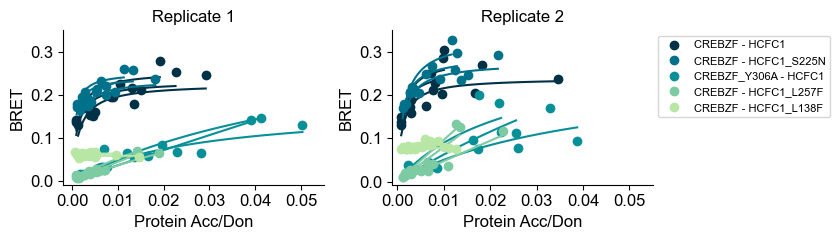

In [18]:
# plot titration curves, fit the data and compute BRET 50
plasmid_pair_sets = [
               [('KL_611','KL_648','Lu126r01','FL01'), ('KL_611','KL_799','Lu126r01','FL01'), 
                ('KL_789','KL_648','Lu126r01','FL01'), ('KL_611','KL_805','Lu126r01','FL01'),
                ('KL_611','KL_800','Lu126r01','FL01')],
               [('KL_611','KL_648','Lu129r01','FL01'), ('KL_611','KL_799','Lu129r01','FL01'), 
                ('KL_789','KL_648','Lu129r01','FL01'), ('KL_611','KL_805','Lu129r01','FL01'),
                ('KL_611','KL_800','Lu129r01','FL01')]#,('KL_789','KL_805','Lu129r01','empty')]
                    ]

labels_colors = {('KL_611','KL_648'):('CREBZF - HCFC1','#003147'),
          ('KL_789','KL_648'):('CREBZF_Y306A - HCFC1','#089099'),
          ('KL_611','KL_799'):('CREBZF - HCFC1_S225N','#00718B'),
          ('KL_611','KL_805'):('CREBZF - HCFC1_L257F','#7CCBA2'),
          ('KL_611','KL_800'):('CREBZF - HCFC1_L138F','#B7E6A5'),
          ('KL_789','KL_805'):('CREBZF_Y306A - HCFC1_L257F','#045275'),}

titles = ['Replicate 1','Replicate 2']

# create dict where data is safed
fit_dict = {}

# create df to save BRET50 and BRETmax
bret50_df = pandas.DataFrame({'pair':[],'project_id':[],'plate_id':[],'bret50':[],'bret50_err':[],'bretmax':[],
                              'bretmax_err':[],'color':[],'NL_plasmid_id':[],'mCit_plasmid_id':[]})

# create df to save BRET values and avg expression values
bret_expr_df = pandas.DataFrame({'project_id':[],'NL_plasmid':[],'mCit_plasmid':[],'NL_property':[],'mCit_property':[],
                                 'BRET':[],'NL_plasmid_id':[],'mCit_plasmid_id':[],'plate_id':[],
                                 'avg_FL':[],'totLu':[],'norm_BRET':[],'expr_ratio':[]})
#set the size of the figure plot
plt.figure(figsize=(8.5,2.5))

for p,plasmid_pairs in enumerate(plasmid_pair_sets):

    plt.subplot(1,2,p+1)

    for i,plasmid_pair in enumerate(plasmid_pairs):
        print(plasmid_pair)
        pair_label = labels_colors[(plasmid_pair[0],plasmid_pair[1])][0]
        pair_color = labels_colors[(plasmid_pair[0],plasmid_pair[1])][1]
        BRET_df = get_saturation_curve_data(plasmid_pair[2],plasmid_pair[0],plasmid_pair[1],connect,plasmid_pair[3])
        BRET_df.sort_values(['plate_id','expr_ratio'],inplace=True)
        print(BRET_df)
        bret_expr_df = bret_expr_df.append(BRET_df,ignore_index=True)
        plate_ids = list(set(list(BRET_df['plate_id'])))
        print(plate_ids)
        
        for plate_id in plate_ids:

            sub_df = BRET_df.loc[BRET_df['plate_id']==plate_id,['expr_ratio','norm_BRET']].reset_index()
            adr_list = sub_df['expr_ratio']
            bret_list = sub_df['norm_BRET']
            # here, create lambda function to define the equation that describes the saturation curve
            func = lambda par,adr : par[0]*adr/(par[1] + adr)
            # ErrorFunc is the diference between the func and the y "experimental" data
            ErrorFunc = lambda par,adr,bret: func(par,adr)-bret
            #tplInitial contains the "first guess" of the parameters 
            Initial1 = (bret_list[len(bret_list)-1],0.01)
            # leastsq finds the parameter bret_max and kd that minimize ErrorFunc=yfit-yExperimental
            #JMS: Changed below line to output all objects from leastsq() - of interest is 'pcov'
            final,pcov,lsdict,lsmesg,success=leastsq(ErrorFunc,Initial1,args=(adr_list,bret_list),full_output=True)
            xx1=np.linspace(adr_list.min(),adr_list.max(),50)
            yy1=func(final,xx1)
            bret_max = final[0]
            bret50 = final[1]

            # JMS: Compute std err for bret50 (according to statistical estimate of error for an estimated parameter)
            #      Calculate residual variance
            s_sq = (ErrorFunc(final,adr_list,bret_list)**2).sum()/(len(bret_list)-len(final))
            #      Multiply residual variance by fractional covariance matrix supplied by leastsq() <- this is the variance-covariance matrix
            pcov = s_sq * pcov
            #      Extract standard error: square root of values along the diagonal of variance-covariance matrix
            sterr_bret50 = (np.absolute(pcov[1][1]))**(1/2)
            sterr_bretmax = (np.absolute(pcov[0][0]))**(1/2)

            # safe data in dict
            xx1_l = xx1.tolist()
            yy1_l = yy1.tolist()
            plasmid_name = "__".join(plasmid_pair)
            data_x_y = {"experiment_name":pair_label,"data" : {"x" : xx1_l, "y": yy1_l}}
            fit_dict[plasmid_name] = data_x_y

            # plot titration curve
            line1 = plt.plot(adr_list,bret_list,linestyle='',color=pair_color,marker='o',label=pair_label)
            # plot fit line
            xx1=np.linspace(adr_list.min(),adr_list.max(),50)
            yy1=func(final,xx1)
            plt.plot(xx1,yy1,linestyle='-',color=pair_color)

            bret50_df = bret50_df.append({'pair':pair_label,'project_id':plasmid_pair[2],'plate_id':plate_id,
                                          'bret50':bret50,'bret50_err':sterr_bret50,'bretmax':bret_max,
                                          'bretmax_err':sterr_bretmax,'color':pair_color,
                                          'NL_plasmid_id':plasmid_pair[0],'mCit_plasmid_id':plasmid_pair[1]},
                                          ignore_index=True)

    plt.title(titles[p],fontsize=12)
    plt.xlabel('Protein Acc/Don',fontsize=12)
    plt.ylabel('BRET',fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(top=0.35)
    plt.xlim(right=0.055)
    ax = plt.gca()
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.spines[['right', 'top']].set_visible(False)
    if p == 1:
        handles, labels = ax.get_legend_handles_labels()
    
artist_collection = []
labels_collection = []
for i in [0,3,6,9,12]:
    artist_collection.append(handles[i])
    labels_collection.append(labels[i])

plt.legend(handles=artist_collection,labels=labels_collection,bbox_to_anchor=(1.0,1.0), fontsize=8)
plt.tight_layout()

df = pandas.DataFrame.from_dict(fit_dict)

plt.savefig(path+'CREBZF_HCFC1_titration_indiv_Lu126r01_Lu129r01.pdf')
plt.savefig(path+'CREBZF_HCFC1_titration_indiv_Lu126r01_Lu129r01.jpeg',dpi=300)
plt.show()

In [19]:
bret50_df

,pair,project_id,plate_id,bret50,bret50_err,bretmax,bretmax_err,color,NL_plasmid_id,mCit_plasmid_id
0,CREBZF - HCFC1,Lu126r01,4.0,1.133966e-03,5.186499e-04,2.553782e-01,2.435800e-02,#003147,KL_611,KL_648
1,CREBZF - HCFC1,Lu126r01,5.0,1.096455e-03,5.853642e-04,2.310465e-01,2.262774e-02,#003147,KL_611,KL_648
2,CREBZF - HCFC1,Lu126r01,6.0,1.552724e-03,7.459077e-04,2.260755e-01,2.113201e-02,#003147,KL_611,KL_648
3,CREBZF - HCFC1_S225N,Lu126r01,4.0,5.680814e-04,1.997579e-04,2.525128e-01,1.429770e-02,#00718B,KL_611,KL_799
4,CREBZF - HCFC1_S225N,Lu126r01,5.0,5.799625e-04,2.748336e-04,2.412336e-01,1.729557e-02,#00718B,KL_611,KL_799
5,CREBZF - HCFC1_S225N,Lu126r01,6.0,9.902116e-04,2.802945e-04,2.347271e-01,1.153381e-02,#00718B,KL_611,KL_799
6,CREBZF_Y306A - HCFC1,Lu126r01,4.0,6.467764e-02,1.531916e-02,3.734088e-01,6.151031e-02,#089099,KL_789,KL_648
7,CREBZF_Y306A - HCFC1,Lu126r01,5.0,2.020337e+00,2.315484e+01,7.238643e+00,8.167289e+01,#089099,KL_789,KL_648
8,CREBZF_Y306A - HCFC1,Lu126r01,6.0,2.774105e-02,2.874958e-02,1.755843e-01,9.150891e-02,#089099,KL_789,KL_648
9,CREBZF - HCFC1_L257F,Lu126r01,4.0,4.229980e-02,3.339334e-02,2.688485e-01,1.688502e-01,#7CCBA2,KL_611,KL_805


In [14]:
bret_expr_df

,project_id,NL_plasmid,mCit_plasmid,NL_property,mCit_property,BRET,NL_plasmid_id,mCit_plasmid_id,plate_id,avg_FL,totLu,norm_BRET,expr_ratio
0,Lu126r01,pcDNA3.1 cmyc-NL-CREBZF,pcDNA3.1 mCit-His3C-HCFC1,2ng,12.5ng,0.4311,KL_611,KL_648,4.0,556.2,271510.0,0.141333,0.000961
1,Lu126r01,pcDNA3.1 cmyc-NL-CREBZF,pcDNA3.1 mCit-His3C-HCFC1,2ng,25ng,0.4590,KL_611,KL_648,4.0,964.0,252588.0,0.169233,0.002680
2,Lu126r01,pcDNA3.1 cmyc-NL-CREBZF,pcDNA3.1 mCit-His3C-HCFC1,2ng,50ng,0.4673,KL_611,KL_648,4.0,856.5,173645.0,0.177533,0.003296
3,Lu126r01,pcDNA3.1 cmyc-NL-CREBZF,pcDNA3.1 mCit-His3C-HCFC1,2ng,100ng,0.4856,KL_611,KL_648,4.0,1652.5,162865.0,0.195833,0.008555
4,Lu126r01,pcDNA3.1 cmyc-NL-CREBZF,pcDNA3.1 mCit-His3C-HCFC1,1ng,100ng,0.5150,KL_611,KL_648,4.0,1928.8,159928.0,0.225233,0.010497
...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,Lu129r01,pcDNA3.1 cmyc-NL-CREBZF,pcDNA3.1 mCit-His3C-HCFC1_L138F,2ng,50ng,0.3661,KL_611,KL_800,3.0,2047.8,952768.0,0.075717,0.001859
176,Lu129r01,pcDNA3.1 cmyc-NL-CREBZF,pcDNA3.1 mCit-His3C-HCFC1_L138F,2ng,25ng,0.3686,KL_611,KL_800,3.0,2500.5,821378.0,0.078217,0.002718
177,Lu129r01,pcDNA3.1 cmyc-NL-CREBZF,pcDNA3.1 mCit-His3C-HCFC1_L138F,1ng,100ng,0.3715,KL_611,KL_800,3.0,4458.0,795736.0,0.081117,0.005299
178,Lu129r01,pcDNA3.1 cmyc-NL-CREBZF,pcDNA3.1 mCit-His3C-HCFC1_L138F,2ng,100ng,0.3753,KL_611,KL_800,3.0,6073.0,803476.0,0.084917,0.007283


In [53]:
avgFL_gr = bret_expr_df.groupby(['project_id','NL_plasmid_id','mCit_plasmid_id','NL_property','mCit_property'])['avg_FL'].aggregate(['mean','std']).reset_index()
print(list(avgFL_gr['mean']))
avgFL_gr.loc[avgFL_gr['project_id']=='Lu126r01',]

  project_id NL_plasmid_id mCit_plasmid_id NL_property mCit_property  \
0   Lu126r01        KL_611          KL_648         1ng         100ng   
1   Lu126r01        KL_611          KL_648         1ng         200ng   
2   Lu126r01        KL_611          KL_648         2ng         100ng   
3   Lu126r01        KL_611          KL_648         2ng        12.5ng   
4   Lu126r01        KL_611          KL_648         2ng          25ng   

          mean         std  
0  1906.433333  119.332574  
1  2485.566667  511.915778  
2  1762.833333  137.230949  
3   561.900000   49.496768  
4   790.900000  151.954697  
<class 'pandas.core.frame.DataFrame'>
[1906.4333333333334, 2485.5666666666666, 1762.8333333333333, 561.9, 790.9, 910.0, 1594.8999999999999, 2528.8333333333335, 1420.4666666666665, 615.6333333333333, 863.3666666666667, 827.3333333333334, 1466.1666666666667, 3139.633333333333, 1516.0, 583.0666666666667, 901.9333333333334, 825.6666666666666, 1270.2666666666667, 2991.0333333333333, 1090.7, 483.

,project_id,NL_plasmid_id,mCit_plasmid_id,NL_property,mCit_property,mean,std
0,Lu126r01,KL_611,KL_648,1ng,100ng,1906.433333,119.332574
1,Lu126r01,KL_611,KL_648,1ng,200ng,2485.566667,511.915778
2,Lu126r01,KL_611,KL_648,2ng,100ng,1762.833333,137.230949
3,Lu126r01,KL_611,KL_648,2ng,12.5ng,561.900000,49.496768
4,Lu126r01,KL_611,KL_648,2ng,25ng,790.900000,151.954697
5,Lu126r01,KL_611,KL_648,2ng,50ng,910.000000,46.446205
6,Lu126r01,KL_611,KL_799,1ng,100ng,1594.900000,186.159958
7,Lu126r01,KL_611,KL_799,1ng,200ng,2528.833333,333.332002
8,Lu126r01,KL_611,KL_799,2ng,100ng,1420.466667,15.505268
9,Lu126r01,KL_611,KL_799,2ng,12.5ng,615.633333,25.652745


('KL_611', 'KL_648', 'Lu126r01', 4)
('KL_611', 'KL_799', 'Lu126r01', 4)
('KL_789', 'KL_648', 'Lu126r01', 4)
('KL_611', 'KL_805', 'Lu126r01', 4)
('KL_611', 'KL_648', 'Lu126r01', 5)
('KL_611', 'KL_799', 'Lu126r01', 5)
('KL_611', 'KL_648', 'Lu126r01', 6)
('KL_611', 'KL_799', 'Lu126r01', 6)
('KL_789', 'KL_648', 'Lu126r01', 6)
('KL_611', 'KL_805', 'Lu126r01', 6)
10
10
10
10
('KL_611', 'KL_648', 'Lu129r01', 1)
('KL_611', 'KL_799', 'Lu129r01', 1)
('KL_789', 'KL_648', 'Lu129r01', 1)
('KL_611', 'KL_648', 'Lu129r01', 2)
('KL_611', 'KL_799', 'Lu129r01', 2)
('KL_789', 'KL_648', 'Lu129r01', 2)
('KL_611', 'KL_648', 'Lu129r01', 3)
('KL_611', 'KL_799', 'Lu129r01', 3)
('KL_789', 'KL_648', 'Lu129r01', 3)
9
9
9
9


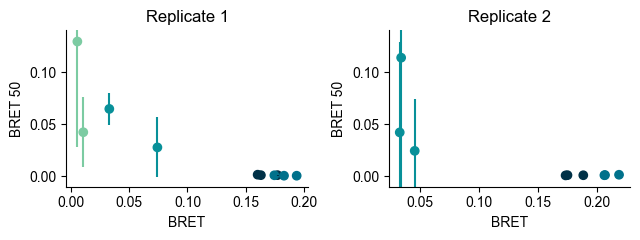

In [36]:
# plot the scatter plot BRET50 vs BRET
plt.figure(figsize=(6.5,2.5))

plasmid_pair_sets = [
               [('KL_611','KL_648','Lu126r01',4), ('KL_611','KL_799','Lu126r01',4), 
                ('KL_789','KL_648','Lu126r01',4), ('KL_611','KL_805','Lu126r01',4),
                ('KL_611','KL_648','Lu126r01',5), ('KL_611','KL_799','Lu126r01',5), 
                ('KL_611','KL_648','Lu126r01',6), ('KL_611','KL_799','Lu126r01',6), 
                ('KL_789','KL_648','Lu126r01',6), ('KL_611','KL_805','Lu126r01',6)],
               [('KL_611','KL_648','Lu129r01',1), ('KL_611','KL_799','Lu129r01',1), 
                ('KL_789','KL_648','Lu129r01',1), 
                ('KL_611','KL_648','Lu129r01',2), ('KL_611','KL_799','Lu129r01',2), 
                ('KL_789','KL_648','Lu129r01',2), 
                ('KL_611','KL_648','Lu129r01',3), ('KL_611','KL_799','Lu129r01',3), 
                ('KL_789','KL_648','Lu129r01',3)]#,('KL_789','KL_805','Lu129r01','empty')]
                    ]

for p,plasmid_pairs in enumerate(plasmid_pair_sets):

    plt.subplot(1,2,p+1)
    BRET_values = []
    BRET50_std = []
    BRET_50_values = []
    colors = []

    for plasmid_pair in plasmid_pairs:
        print(plasmid_pair)
        BRET_values = BRET_values + list(bret_expr_df.loc[(bret_expr_df['NL_property']=='2ng') & 
                                          (bret_expr_df['mCit_property']=='50ng') & 
                                          (bret_expr_df['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (bret_expr_df['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (bret_expr_df['project_id']==plasmid_pair[2]) & 
                                          (bret_expr_df['plate_id']==plasmid_pair[3]),'norm_BRET'])

        BRET_50_values = BRET_50_values + list(bret50_df.loc[(bret50_df['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (bret50_df['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (bret50_df['project_id']==plasmid_pair[2]) & 
                                          (bret50_df['plate_id']==plasmid_pair[3]),'bret50'])

        BRET50_std = BRET50_std + list(bret50_df.loc[(bret50_df['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (bret50_df['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (bret50_df['project_id']==plasmid_pair[2]) & 
                                          (bret50_df['plate_id']==plasmid_pair[3]),'bret50_err'])
 
        colors = colors + list(bret50_df.loc[(bret50_df['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (bret50_df['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (bret50_df['project_id']==plasmid_pair[2]) & 
                                          (bret50_df['plate_id']==plasmid_pair[3]),'color'])

    
    print(len(BRET_values))
    print(len(BRET_50_values))
    print(len(BRET50_std))
    print(len(colors))

    plt.errorbar(BRET_values,BRET_50_values,yerr=BRET50_std,marker='',linestyle='',ecolor=colors)
    plt.scatter(BRET_values,BRET_50_values,marker='o',color=colors)
    plt.title(titles[p],fontsize=12)
    plt.ylabel('BRET 50',fontsize=10)
    plt.xlabel('BRET',fontsize=10)
#    plt.yscale("log")
    plt.ylim((-0.01,0.14))
#    plt.ylim(top=0.2)
#     plt.xlim((0,0.18))
    ax = plt.gca()
    ax.spines[['right', 'top']].set_visible(False)

plt.tight_layout()
plt.savefig(path+'CREBZF_HCFC1_expr_BRET50err_vs_BRET_Lu126r01_Lu129r01.pdf')
plt.savefig(path+'SNRPB_GIGYF1_expr_BRET50err_vs_BRET_Lu126r01_Lu129r01.jpeg',dpi=300)
plt.show()

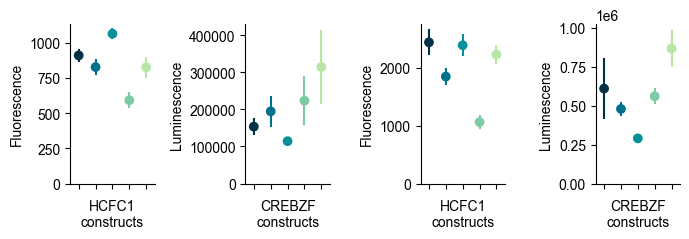

In [58]:
# plot the expression values for both partner proteins

plasmid_pair_sets = [
               [('KL_611','KL_648','Lu126r01','FL01'), ('KL_611','KL_799','Lu126r01','FL01'), 
                ('KL_789','KL_648','Lu126r01','FL01'), ('KL_611','KL_805','Lu126r01','FL01'),
                ('KL_611','KL_800','Lu126r01','FL01')],
               [('KL_611','KL_648','Lu129r01','FL01'), ('KL_611','KL_799','Lu129r01','FL01'), 
                ('KL_789','KL_648','Lu129r01','FL01'), ('KL_611','KL_805','Lu129r01','FL01'),
                ('KL_611','KL_800','Lu129r01','FL01')]#,('KL_789','KL_805','Lu129r01','empty')]
                    ]

plt.figure(figsize=(7,2.5))

avgFL_gr = bret_expr_df.groupby(['project_id','NL_plasmid_id','mCit_plasmid_id','NL_property','mCit_property'])['avg_FL'].aggregate(['mean','std']).reset_index()
avgLU_gr = bret_expr_df.groupby(['project_id','NL_plasmid_id','mCit_plasmid_id','NL_property','mCit_property'])['totLu'].aggregate(['mean','std']).reset_index()

for p,plasmid_pairs in enumerate(plasmid_pair_sets):

    plt.subplot(1,4,p*2+1)
    FL_values = []
    FL_std = []
    colors = []

    for plasmid_pair in plasmid_pairs:
        FL_values.append(list(avgFL_gr.loc[(avgFL_gr['NL_property']=='2ng') & 
                                          (avgFL_gr['mCit_property']=='50ng') & 
                                          (avgFL_gr['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (avgFL_gr['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (avgFL_gr['project_id']==plasmid_pair[2]),'mean'])[0])

        FL_std.append(list(avgFL_gr.loc[(avgFL_gr['NL_property']=='2ng') & 
                                          (avgFL_gr['mCit_property']=='50ng') & 
                                          (avgFL_gr['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (avgFL_gr['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (avgFL_gr['project_id']==plasmid_pair[2]),'std'])[0])
 
        colors.append(labels_colors[(plasmid_pair[0],plasmid_pair[1])][1])

    plt.errorbar(range(len(FL_values)),FL_values,yerr=FL_std,marker='',linestyle='',ecolor=colors)
    plt.scatter(range(len(FL_values)),FL_values,marker='o',color=colors)
    plt.ylabel('Fluorescence',fontsize=10)
    plt.xlabel('HCFC1\nconstructs',fontsize=10)
    plt.ylim(bottom=0)
    plt.xlim(-0.5,len(FL_values)-0.5)
    plt.xticks(range(len(FL_values)),'')
    ax = plt.gca()
    ax.spines[['right', 'top']].set_visible(False)


    plt.subplot(1,4,p*2+2)
    LU_values = []
    LU_std = []

    for plasmid_pair in plasmid_pairs:
        LU_values.append(list(avgLU_gr.loc[(avgLU_gr['NL_property']=='2ng') & 
                                          (avgLU_gr['mCit_property']=='50ng') & 
                                          (avgLU_gr['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (avgLU_gr['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (avgLU_gr['project_id']==plasmid_pair[2]),'mean'])[0])

        LU_std.append(list(avgLU_gr.loc[(avgLU_gr['NL_property']=='2ng') & 
                                          (avgLU_gr['mCit_property']=='50ng') & 
                                          (avgLU_gr['NL_plasmid_id']==plasmid_pair[0]) & 
                                          (avgLU_gr['mCit_plasmid_id']==plasmid_pair[1]) & 
                                          (avgLU_gr['project_id']==plasmid_pair[2]),'std'])[0])
 

    plt.errorbar(range(len(LU_values)),LU_values,yerr=LU_std,marker='',linestyle='',ecolor=colors)
    plt.scatter(range(len(LU_values)),LU_values,marker='o',color=colors)
    plt.ylabel('Luminescence',fontsize=10)
    plt.xlabel('CREBZF\nconstructs',fontsize=10)
    plt.xticks(range(len(LU_values)),'')
    plt.ylim(bottom=0)
    plt.xlim(-0.5,len(LU_values)-0.5)
    ax = plt.gca()
    ax.spines[['right', 'top']].set_visible(False)

    
plt.tight_layout()
plt.savefig(path+'CREBZF_HCFC1_expr_Lu126r01_Lu129r01.pdf')
plt.savefig(path+'CREBZF_HCFC1_expr_Lu126r01_Lu129r01.jpeg',dpi=300)
plt.show()